# PM2.5 Regional Analysis

This notebook demonstrates how to analyze PM2.5 data for geographic regions using GeoJSON files.

In [1]:
from vayuayan import PM25Client
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import json

## 1. Understanding PM2.5 Data

PM2.5 refers to fine particulate matter with a diameter of 2.5 micrometers or smaller. This data is sourced from satellite imagery and provides global coverage.

**Data Source:** The package uses netCDF files containing PM2.5 measurements at 0.1-degree resolution.

## 2. Initialize PM2.5 Client

First, let's initialize the PM2.5 client.

In [2]:
# Initialize PM2.5 client
pm25_client = PM25Client()

print("PM2.5 Client initialized successfully")

PM2.5 Client initialized successfully


## 3. Create a Sample GeoJSON File

For this example, we'll create a simple GeoJSON file representing a region of interest.

**Note:** You can use any GeoJSON file with your own boundaries.

In [3]:
# Example: Create a simple GeoJSON for a rectangular region
# This example covers approximately the Mumbai metropolitan area

sample_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {
                "name": "Mumbai Region",
                "id": "mumbai_001"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [72.7, 18.9],  # Southwest corner
                    [73.1, 18.9],  # Southeast corner
                    [73.1, 19.3],  # Northeast corner
                    [72.7, 19.3],  # Northwest corner
                    [72.7, 18.9]   # Close the polygon
                ]]
            }
        }
    ]
}

# Save to file
geojson_file = "mumbai_region.geojson"
with open(geojson_file, 'w') as f:
    json.dump(sample_geojson, f, indent=2)

print(f"Sample GeoJSON created: {geojson_file}")

Sample GeoJSON created: mumbai_region.geojson


## 4. Visualize the GeoJSON Region

Let's visualize the region we'll be analyzing.

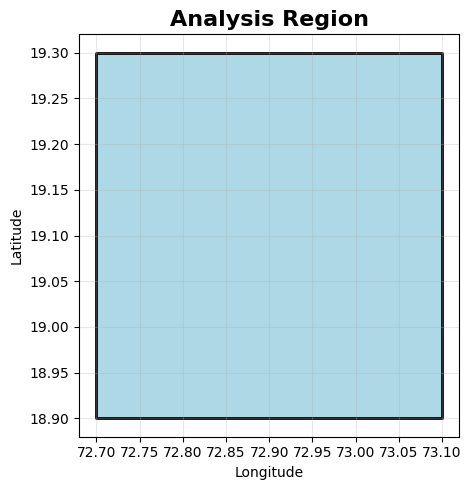


Region Details:
Name: Mumbai Region
Bounds: [72.7 18.9 73.1 19.3]


In [4]:
# Load and visualize the GeoJSON
gdf = gpd.read_file(geojson_file)

fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, facecolor='lightblue', edgecolor='black', linewidth=2)
ax.set_title('Analysis Region', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nRegion Details:")
print(f"Name: {gdf['name'].iloc[0]}")
print(f"Bounds: {gdf.total_bounds}")

## 5. Get PM2.5 Statistics for the Region

Now let's fetch PM2.5 statistics for the entire region.

**Note:** This requires the PM2.5 netCDF data files to be available locally.

In [ ]:
# Get PM2.5 statistics for the region
# Specify year and optionally month

year = 2019
month = 2  # February (optional, leave as None for annual data)

try:
    stats = pm25_client.get_pm25_stats(geojson_file, year, month)
    
    print(f"PM2.5 Statistics for {year}/{month if month else 'Annual'}:")
    print(f"\nMean PM2.5: {stats['mean']:.2f} μg/m³")
    print(f"Standard Deviation: {stats['std']:.2f} μg/m³")
    print(f"Minimum PM2.5: {stats['min']:.2f} μg/m³")
    print(f"Maximum PM2.5: {stats['max']:.2f} μg/m³")
    
    # Interpret the results
    if stats['mean'] <= 12:
        category = "✅ Good (WHO guideline)"
    elif stats['mean'] <= 35.4:
        category = "🟢 Moderate"
    elif stats['mean'] <= 55.4:
        category = "🟡 Unhealthy for Sensitive Groups"
    elif stats['mean'] <= 150.4:
        category = "🟠 Unhealthy"
    elif stats['mean'] <= 250.4:
        category = "🔴 Very Unhealthy"
    else:
        category = "🆘 Hazardous"
    
    print(f"\nAir Quality Category: {category}")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("\nNote: This requires PM2.5 netCDF data files.")
    print("Download from: https://sites.wustl.edu/acag/datasets/surface-pm2-5/")

Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.201902-201902.nc
PM2.5 Statistics for 2019/2:

Mean PM2.5: 57.03 μg/m³
Standard Deviation: 10.46 μg/m³
Minimum PM2.5: 11.24 μg/m³
Maximum PM2.5: 85.70 μg/m³

Air Quality Category: 🟠 Unhealthy


## 6. Analyze Multiple Sub-Regions

If your GeoJSON contains multiple polygons, you can analyze each separately.

In [9]:
# Create a GeoJSON with multiple districts
multi_region_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {"district_name": "North Mumbai", "id": 1},
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[72.8, 19.1], [72.9, 19.1], [72.9, 19.2], [72.8, 19.2], [72.8, 19.1]]]
            }
        },
        {
            "type": "Feature",
            "properties": {"district_name": "South Mumbai", "id": 2},
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[72.8, 18.9], [72.9, 18.9], [72.9, 19.0], [72.8, 19.0], [72.8, 18.9]]]
            }
        }
    ]
}

multi_geojson_file = "mumbai_districts.geojson"
with open(multi_geojson_file, 'w') as f:
    json.dump(multi_region_geojson, f, indent=2)

print(f"Multi-region GeoJSON created: {multi_geojson_file}")

Multi-region GeoJSON created: mumbai_districts.geojson


In [14]:
# Get PM2.5 statistics for each polygon
try:
    results = pm25_client.get_pm25_stats(
        multi_geojson_file, 
        year=2019, 
        month=2,
        group_by="district_name"
    )
    
    # Convert to DataFrame for better visualization
    df_results = pd.DataFrame(results)
    
    print("PM2.5 Statistics by District:")
    print(df_results[['district_name', 'mean', 'std', 'min', 'max', 'count']])
    
    # Find district with highest pollution
    worst_district = df_results.loc[df_results['mean'].idxmax()]
    print(f"\nMost Polluted District: {worst_district['district_name']}")
    print(f"Average PM2.5: {worst_district['mean']:.2f} μg/m³")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Note: This requires PM2.5 netCDF data files.")

Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.201902-201902.nc
PM2.5 Statistics by District:
  district_name       mean        std        min        max  count
0  North Mumbai  65.923286   6.329509  53.312996  82.914391    112
1  South Mumbai  47.832973  10.138418  11.241808  68.667816    112

Most Polluted District: North Mumbai
Average PM2.5: 65.92 μg/m³


## 7. Visualize PM2.5 Distribution

Create a choropleth map showing PM2.5 levels across districts.

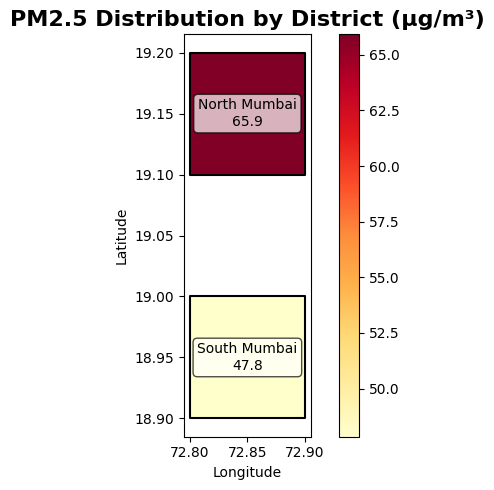

In [17]:
# Load the multi-region GeoJSON
gdf_multi = gpd.read_file(multi_geojson_file)

# Merge with results if available
try:
    # Merge PM2.5 data with geodataframe
    gdf_with_pm25 = gdf_multi.merge(
        df_results[['district_name', 'mean']], 
        left_on='district_name', 
        right_on='district_name'
    )
    
    # Create choropleth map
    fig, ax = plt.subplots(figsize=(6, 5))
    gdf_with_pm25.plot(
        column='mean', 
        ax=ax, 
        legend=True,
        cmap='YlOrRd',
        edgecolor='black',
        linewidth=1.5
    )
    
    # Add district labels
    for idx, row in gdf_with_pm25.iterrows():
        centroid = row.geometry.centroid
        ax.text(
            centroid.x, centroid.y, 
            f"{row['district_name']}\n{row['mean']:.1f}",
            ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
        )
    
    ax.set_title('PM2.5 Distribution by District (μg/m³)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.tight_layout()
    plt.show()
    
except NameError:
    print("PM2.5 data not available. Run the previous cell first.")

## 8. Temporal Analysis

Compare PM2.5 levels across different months.

Analyzing monthly PM2.5 levels...

Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202301-202301.nc
Month 1: 80.09 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202302-202302.nc
Month 2: 64.29 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202303-202303.nc
Month 3: 53.60 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202304-202304.nc
Month 4: 36.48 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202305-202305.nc
Month 5: 26.17 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202306-202306.nc
Month 6: 22.40 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202307-202307.nc
Month 7: 21.68 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202308-202308.nc
Month 8: 18.28 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202309-202309.nc
Month 9: 29.46 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202310-202310.nc
Month 10: 67.41 μg/m³
Using cached file: pm25_data\V6GL02.04.CNNPM25.GL.202311-202311.nc
Month 11: 65.40 μ

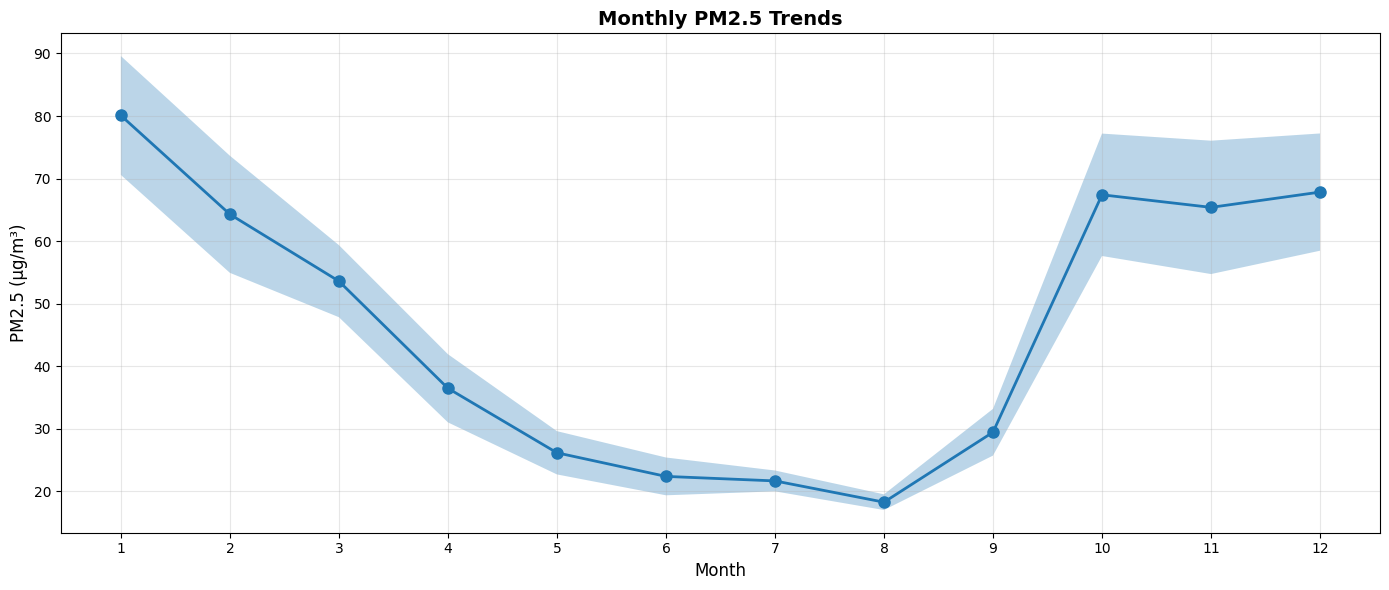


Worst Month: 1.0 (80.09 μg/m³)
Best Month: 8.0 (18.28 μg/m³)


In [ ]:
# Analyze PM2.5 for multiple months
months = range(1, 13)  # All 12 months
monthly_data = []

print("Analyzing monthly PM2.5 levels...\n")

for month in months:
    try:
        stats = pm25_client.get_pm25_stats(geojson_file, 2023, month)
        monthly_data.append({
            'Month': month,
            'Mean_PM25': stats['mean'],
            'Std_PM25': stats['std'],
        })
        print(f"Month {month}: {stats['mean']:.2f} μg/m³")
    except Exception as e:
        print(f"Month {month}: Data not available : {e}")

if monthly_data:
    # Create DataFrame
    df_monthly = pd.DataFrame(monthly_data)
    
    # Plot monthly trends
    plt.figure(figsize=(14, 6))
    plt.plot(df_monthly['Month'], df_monthly['Mean_PM25'], marker='o', linewidth=2, markersize=8)
    plt.fill_between(
        df_monthly['Month'], 
        df_monthly['Mean_PM25'] - df_monthly['Std_PM25'],
        df_monthly['Mean_PM25'] + df_monthly['Std_PM25'],
        alpha=0.3
    )
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('PM2.5 (μg/m³)', fontsize=12)
    plt.title('Monthly PM2.5 Trends', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, 13))
    plt.tight_layout()
    plt.show()
    
    # Find worst and best months
    worst_month = df_monthly.loc[df_monthly['Mean_PM25'].idxmax()]
    best_month = df_monthly.loc[df_monthly['Mean_PM25'].idxmin()]
    
    print(f"\nWorst Month: {worst_month['Month']} ({worst_month['Mean_PM25']:.2f} μg/m³)")
    print(f"Best Month: {best_month['Month']} ({best_month['Mean_PM25']:.2f} μg/m³)")

## 9. Export Results

Save the analysis results for future reference.

In [20]:
# Export results to CSV
if 'df_results' in locals():
    output_file = "pm25_analysis_results.csv"
    df_results.to_csv(output_file, index=False)
    print(f"District-level results saved to: {output_file}")

if 'df_monthly' in locals():
    monthly_output = "pm25_monthly_trends.csv"
    df_monthly.to_csv(monthly_output, index=False)
    print(f"Monthly trends saved to: {monthly_output}")

District-level results saved to: pm25_analysis_results.csv
Monthly trends saved to: pm25_monthly_trends.csv


## Conclusion

This notebook demonstrated:
- Setting up PM2.5 analysis with GeoJSON regions
- Calculating PM2.5 statistics for geographic areas
- Analyzing multiple sub-regions
- Visualizing spatial distribution
- Temporal trend analysis
- Exporting results

**Next Steps:**
- Integrate with other environmental data
- Create automated reports
- Set up alerts for high pollution events
- Compare different regions